One of the features added for the v2022.03 RDKit release is support for "Reaxys/Beilstein" generic groups - atoms with labels like "ARY" or "ACY" which can be used to make substructure searches more specific.

This post provides a quick overview of that functionality.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolEnumerator
from rdkit.Chem import rdTautomerQuery
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.minFontSize = 10
IPythonConsole.molSize = 350,300

Draw.SetComicMode(IPythonConsole.drawOptions)
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import rdkit
print(rdkit.__version__)
import time
print(time.asctime())

2022.03.1
Tue Apr  5 05:02:20 2022


Load a `SubstructLibrary` created using ChEMBL_30.
The code used to construct this is:
```
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import rdSubstructLibrary
import pickle, time
import gzip
import numpy as np

gz = gzip.GzipFile('/home/glandrum/Downloads/chembl_30.sdf.gz')
suppl = Chem.ForwardSDMolSupplier(gz)
RDLogger.DisableLog("rdApp.warning")
t1=time.time()
data = []
for i,mol in enumerate(suppl):
    if not ((i+1)%50000):
        print(f"Processed {i+1} molecules in {(time.time()-t1):.1f} seconds")
    if mol is None or mol.GetNumHeavyAtoms()>50:
        continue
    fp = Chem.PatternFingerprint(mol,fpSize=1024,tautomerFingerprints=True)
    smi = Chem.MolToSmiles(mol)
    data.append((smi,fp,mol.GetNumHeavyAtoms()))
t2=time.time()
pickle.dump(data,open('./results/chembl30_sssdata.pkl','wb+'))
t1=time.time()
mols = rdSubstructLibrary.CachedTrustedSmilesMolHolder()
fps = rdSubstructLibrary.TautomerPatternHolder(1024)
natoms = []
for smi,fp,nats in data:
    mols.AddSmiles(smi)
    fps.AddFingerprint(fp)
    natoms.append(nats)
library = rdSubstructLibrary.SubstructLibrary(mols,fps)
library.SetSearchOrder([int(x) for x in np.argsort(natoms)])

t2=time.time()
print(f"That took {t2-t1:.2f} seconds. The library has {len(library)} molecules.")
pickle.dump(library,open('./results/chembl30_ssslib.pkl','wb+'))
```

In [2]:
import pickle
with open('./results/chembl30_ssslib.pkl','rb') as inf:
    sslib = pickle.load(inf)
print(f'SubstructLibrary loaded with {len(sslib)} molecules')

SubstructLibrary loaded with 2035013 molecules


# Beilstein generic queries

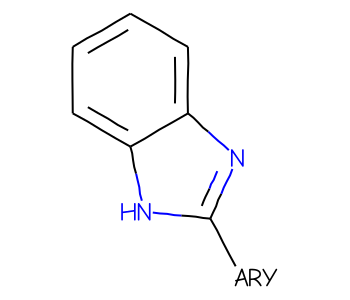

In [3]:
mb = '''
  Mrv2108 03242208122D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 10 11 1 0 0
M  V30 BEGIN ATOM
M  V30 1 C -9.3333 2.6234 0 0
M  V30 2 C -10.667 1.8534 0 0
M  V30 3 C -10.667 0.3133 0 0
M  V30 4 C -9.3333 -0.4567 0 0
M  V30 5 C -7.9997 0.3133 0 0
M  V30 6 C -7.9997 1.8534 0 0
M  V30 7 N -9.0131 -1.963 0 0
M  V30 8 C -7.4816 -2.124 0 0
M  V30 9 N -6.8552 -0.7171 0 0
M  V30 10 C -6.7586 -3.4837 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 8
M  V30 8 1 5 9
M  V30 9 1 4 7
M  V30 10 2 8 9
M  V30 11 1 8 10
M  V30 END BOND
M  V30 BEGIN SGROUP
M  V30 1 SUP 0 ATOMS=(1 10) SAP=(3 10 8 1) XBONDS=(1 11) LABEL=ARY
M  V30 END SGROUP
M  V30 END CTAB
M  END
'''
bqry = Chem.MolFromMolBlock(mb)

# show labels for the Sgroups:
for sgs in Chem.GetMolSubstanceGroups(bqry):
    if sgs.GetProp('TYPE') == 'SUP':
        bqry.GetAtomWithIdx(sgs.GetAtoms()[0]).SetProp("atomLabel",sgs.GetProp("LABEL"))
bqry

Initially the generic `ARY` query is not used in the substructure search:

There are 1000 matches


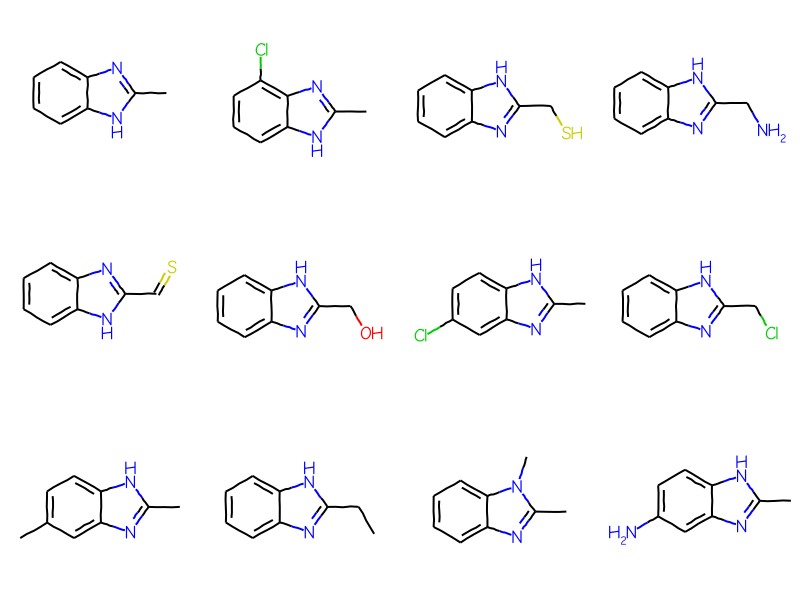

In [4]:
matches = sslib.GetMatches(bqry)
mols = [sslib.GetMol(x) for x in matches]
print(f'There are {len(mols)} matches')
Draw.MolsToGridImage(mols[:12],molsPerRow=4)


But we can limit the results to aryl substituents by expanding the generic query and telling the SubstructLib to use it:

There are 1000 matches


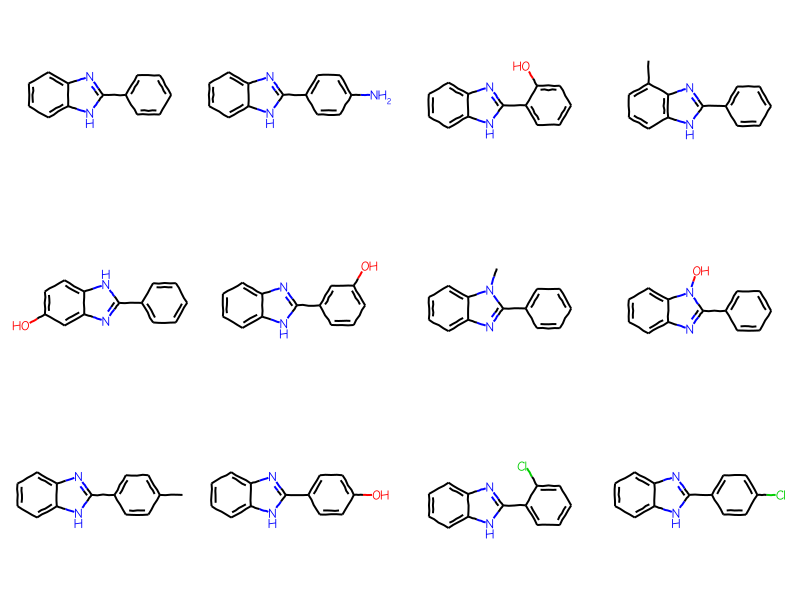

In [5]:
ary_qry = Chem.Mol(bqry)

# expand the query:
Chem.SetGenericQueriesFromProperties(ary_qry)

# do the search using generic query matchers:
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
matches = sslib.GetMatches(ary_qry,params)

mols = [sslib.GetMol(x) for x in matches]
print(f'There are {len(mols)} matches')
Draw.MolsToGridImage(mols[:12],molsPerRow=4)


The full list of recognized generic atoms is here:
https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/GenericGroups/GenericGroups.h#L245

Here are a couple of more examples

`AHC`: heteroacyclic groups

There are 1000 matches


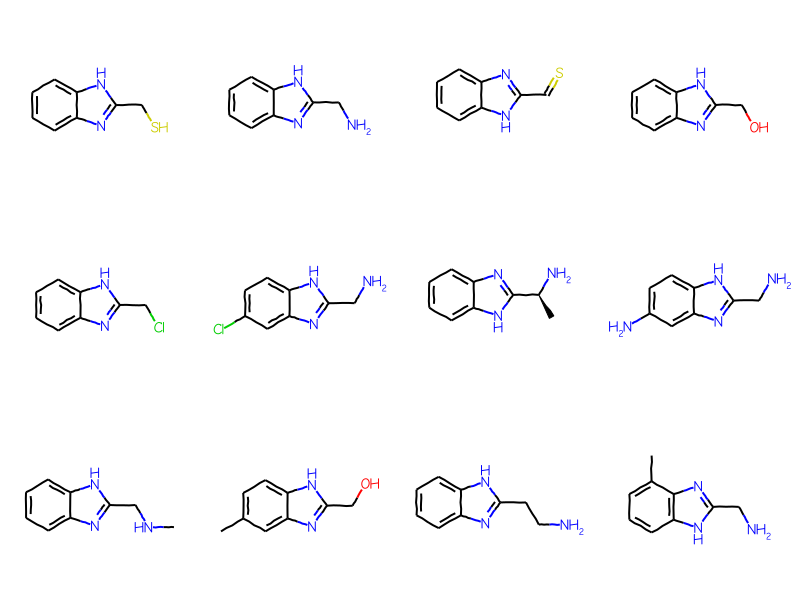

In [6]:
mb = '''
  Mrv2108 03242208122D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 10 11 1 0 0
M  V30 BEGIN ATOM
M  V30 1 C -9.3333 2.6234 0 0
M  V30 2 C -10.667 1.8534 0 0
M  V30 3 C -10.667 0.3133 0 0
M  V30 4 C -9.3333 -0.4567 0 0
M  V30 5 C -7.9997 0.3133 0 0
M  V30 6 C -7.9997 1.8534 0 0
M  V30 7 N -9.0131 -1.963 0 0
M  V30 8 C -7.4816 -2.124 0 0
M  V30 9 N -6.8552 -0.7171 0 0
M  V30 10 C -6.7586 -3.4837 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 8
M  V30 8 1 5 9
M  V30 9 1 4 7
M  V30 10 2 8 9
M  V30 11 1 8 10
M  V30 END BOND
M  V30 BEGIN SGROUP
M  V30 1 SUP 0 ATOMS=(1 10) SAP=(3 10 8 1) XBONDS=(1 11) LABEL=AHC
M  V30 END SGROUP
M  V30 END CTAB
M  END
'''
bqry = Chem.MolFromMolBlock(mb)

# show labels for the Sgroups:
for sgs in Chem.GetMolSubstanceGroups(bqry):
    if sgs.GetProp('TYPE') == 'SUP':
        bqry.GetAtomWithIdx(sgs.GetAtoms()[0]).SetProp("atomLabel",sgs.GetProp("LABEL"))
ahc_qry = Chem.Mol(bqry)

# expand the query:
Chem.SetGenericQueriesFromProperties(ahc_qry)

# do the search using generic query matchers:
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
matches = sslib.GetMatches(ahc_qry,params)

mols = [sslib.GetMol(x) for x in matches]
print(f'There are {len(mols)} matches')
Draw.MolsToGridImage(mols[:12],molsPerRow=4)

`CAL`: carbocyclic alkyl

There are 784 matches


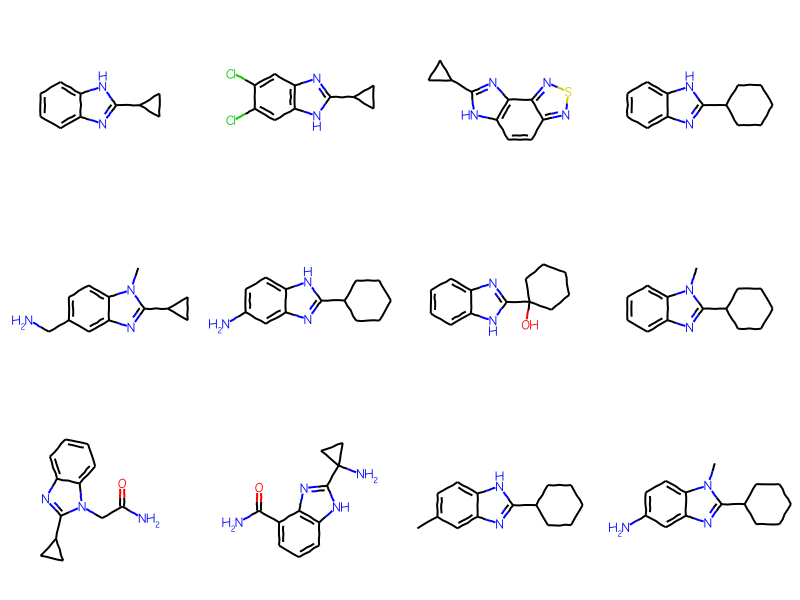

In [7]:
mb = '''
  Mrv2108 03242208122D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 10 11 1 0 0
M  V30 BEGIN ATOM
M  V30 1 C -9.3333 2.6234 0 0
M  V30 2 C -10.667 1.8534 0 0
M  V30 3 C -10.667 0.3133 0 0
M  V30 4 C -9.3333 -0.4567 0 0
M  V30 5 C -7.9997 0.3133 0 0
M  V30 6 C -7.9997 1.8534 0 0
M  V30 7 N -9.0131 -1.963 0 0
M  V30 8 C -7.4816 -2.124 0 0
M  V30 9 N -6.8552 -0.7171 0 0
M  V30 10 C -6.7586 -3.4837 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 8
M  V30 8 1 5 9
M  V30 9 1 4 7
M  V30 10 2 8 9
M  V30 11 1 8 10
M  V30 END BOND
M  V30 BEGIN SGROUP
M  V30 1 SUP 0 ATOMS=(1 10) SAP=(3 10 8 1) XBONDS=(1 11) LABEL=CAL
M  V30 END SGROUP
M  V30 END CTAB
M  END
'''
bqry = Chem.MolFromMolBlock(mb)

cal_qry = Chem.Mol(bqry)

# expand the query:
Chem.SetGenericQueriesFromProperties(cal_qry)

# do the search using generic query matchers:
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
matches = sslib.GetMatches(cal_qry,params)

mols = [sslib.GetMol(x) for x in matches]
print(f'There are {len(mols)} matches')
Draw.MolsToGridImage(mols[:12],molsPerRow=4)


# Providing the queries in CXSMILES

You can also use CXSMILES/CXSMARTS to provide these queries:

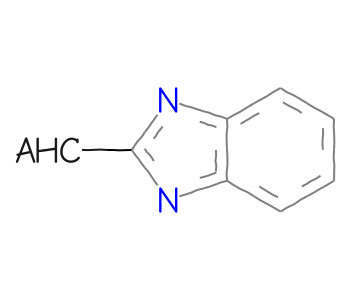

In [48]:
# AHC: heteroacyclic
sqry = Chem.MolFromSmarts('*-c1nc2c(n1)cccc2 |$AHC;;;;;;;;;$|')
sqry

There are 1000 matches


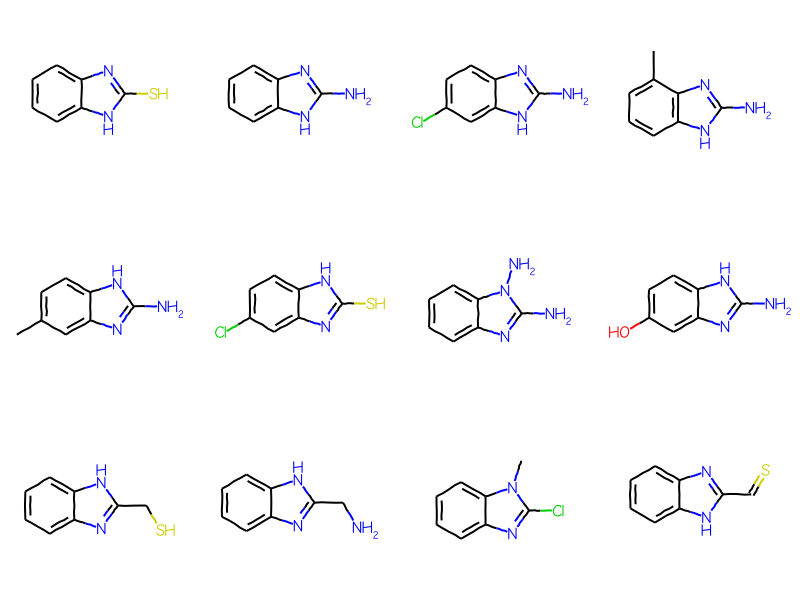

In [50]:
ahc_qry = Chem.Mol(sqry)
# expand the query:
Chem.SetGenericQueriesFromProperties(ahc_qry)

# do the search using generic query matchers:
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
matches = sslib.GetMatches(ahc_qry,params)

mols = [sslib.GetMol(x) for x in matches]
print(f'There are {len(mols)} matches')
Draw.MolsToGridImage(mols[:12],molsPerRow=4)


Though note that if you use CXSMILES it's important to make sure the dummy atom is replaced with a query before doing the search. If you don't do so, you'll get no results since the dummy atom only matches other dummy atoms:

In [55]:
sqry = Chem.MolFromSmiles('*C1=NC2=C(N1)C=CC=C2 |$AHC;;;;;;;;;$|')
ahc_qry = Chem.Mol(sqry)
# expand the query:
Chem.SetGenericQueriesFromProperties(ahc_qry)

params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
matches = sslib.GetMatches(ahc_qry,params)
print(f'There are {len(matches)} matches')

There are 0 matches


Here's the fix:

In [56]:
qps = Chem.AdjustQueryParameters.NoAdjustments()
qps.makeDummiesQueries = True
sqry = Chem.AdjustQueryProperties(sqry)

ahc_qry = Chem.Mol(sqry)
Chem.SetGenericQueriesFromProperties(ahc_qry)
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
matches = sslib.GetMatches(ahc_qry,params)
print(f'There are {len(matches)} matches')

There are 186 matches


# Search performance

Get a baseline for how long a search takes by ignoring the generic matchers:

In [8]:
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = False
%timeit matches = sslib.GetMatches(cal_qry,params,maxResults=5000)


330 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We'd expect the searches using generic groups to take at least a bit longer since they will results in more molecules being scanned until we find our 5000 results. 
The big question is whether or not merely including the generic queries results in a significant slow down.

Let's test how much longer it takes using two of the different generic groups:

In [11]:
# Start with "CAL"
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
%timeit matches = sslib.GetMatches(cal_qry,params,maxResults=5000)


382 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That really doesn't make much of a difference at all.

In [12]:
# "ARY"
params = Chem.SubstructMatchParameters()
params.useGenericMatchers = True
%timeit matches = sslib.GetMatches(ary_qry,params,maxResults=5000)


1.1 s ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So there is definitely some impact, and it depends on which generic query is being used.

## Aside

Since the ARY query mainly returns molecules which have a phenyl group attached at the ARY position, let's compare search performance with a query where we explicitly include the phenyl. Here the extra atoms/bonds will slow the substructure search down but they will also make the fingerprint screenout more effective. The question is which effect is dominant.

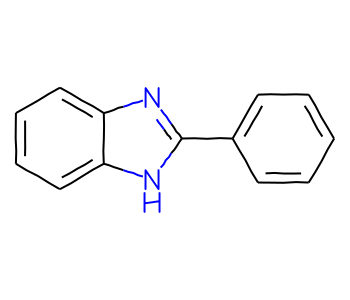

In [13]:
fullqry = Chem.MolFromSmiles('c1ccccc1-c1nc2ccccc2[nH]1')
fullqry

In [15]:
%timeit matches = sslib.GetMatches(fullqry,maxResults=5000)


971 ms ± 5.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In this case the larger query is a bit faster.

It's worth mentioning that the query with the phenyl group returns different search results than the version with the ARY:

In [20]:
full_matches = sslib.GetMatches(fullqry,params,maxResults=-1)
ary_matches = sslib.GetMatches(ary_qry,params,maxResults=-1)
len(full_matches),len(ary_matches)

(6866, 6488)

There are 379 matches


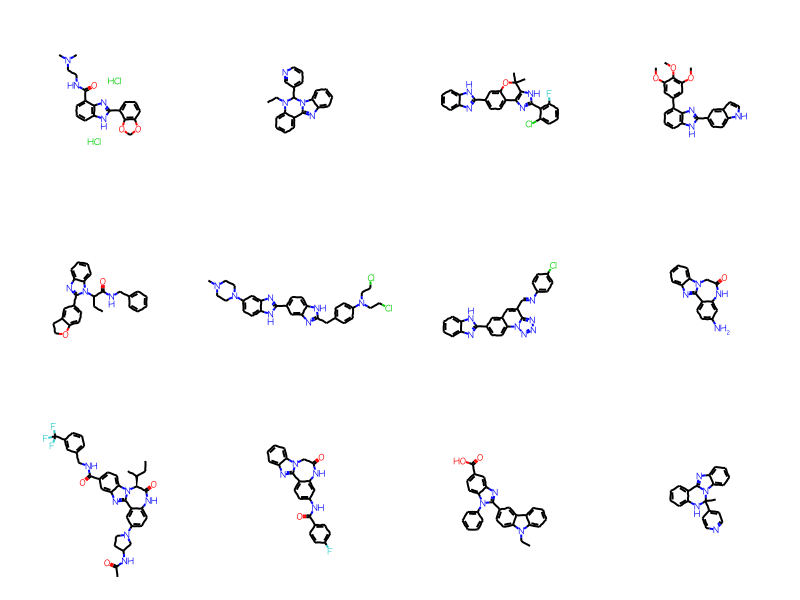

In [21]:
full_not_ary = set(full_matches).difference(ary_matches)
mols = [sslib.GetMol(x) for x in full_not_ary]
print(f'There are {len(mols)} matches')
Draw.MolsToGridImage(mols[:12],molsPerRow=4)


As you'd expect, there are a bunch of molecules with heterocyclic aromatic systems here. The ARY query only matches carboaryl systems.

There is only one molecule returned by the ARY query but not the full query; this one has an unusual aromatic ring system:

There are 1 matches


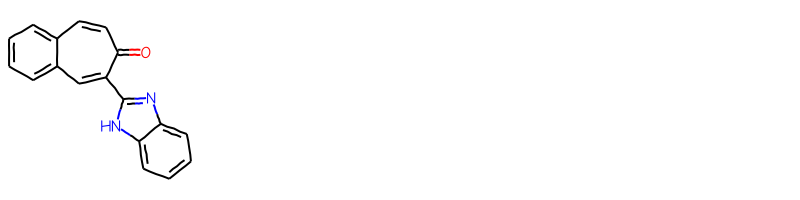

In [23]:
ary_not_full = set(ary_matches).difference(full_matches)
mols = [sslib.GetMol(x) for x in ary_not_full]
print(f'There are {len(mols)} matches')
Draw.MolsToGridImage(mols[:12],molsPerRow=4)

That's a good one to ignite a round of "but that's not aromatic!" arguments, but before you start down that road, please read this section of the RDKit docs: https://www.rdkit.org/docs/RDKit_Book.html#aromaticity and possibly the section on aromaticity in the [Daylight Theory manual](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html).

This seems like a great place to close this post. :-)